### Домашнее задание №7

Практическое задание:
1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2.  сделать обзорный анализ выбранного датасета
3.  сделать feature engineering
4.  обучить любой классификатор (какой вам нравится)
5.  разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
6.  для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

#### 1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
#### 2.  сделать обзорный анализ выбранного датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
import shap
import xgboost
# load JS visualization code to notebook
shap.initjs()

df = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


Для работы взят датасет, описывающий отток клиентов телекоммуникационной компании.
Каждая строка представляет клиента, каждый столбец содержит атрибуты клиента, описанные в столбце Метаданные.

Набор данных включает в себя следующую информацию:  
Клиенты, которые вышли в течение последнего месяца - колонка называется Churn  
Услуги, на которые подписался каждый клиент - телефон, несколько линий, интернет, онлайн-безопасность, онлайн-резервное копирование, защита устройства, техническая поддержка, потоковое телевидение и фильмы  
Информация об учетной записи клиента - как долго они были клиентом, контракт, способ оплаты, безбумажный биллинг, ежемесячные платежи и общие расходы  
Демографическая информация о клиентах - пол, возраст, а также наличие партнеров и иждивенцев. Для обучения модели и дальшейших предсказаний берутся не все признаки, а только следующие:  

'gender' - пол клиента  
'tenure' - срок пользования услугами компании в месяцах  
'PhoneService' - использование телефонных услуг  
'TotalCharges' - общие расходы  
'StreamingMovies' - потоковые фильмы  
'StreamingTV' - потоковое ТВ  
'TechSupport' - использование технической поддержки  
'Churn' - целефой показатель (1 - отток, 0 - отсутсвие оттока)  

#### 3.  сделать feature engineering

In [2]:
# Сделайте замену значений поля PhoneService  на числовые (Yes->1, No->0)а
df['PhoneService'] = np.where((df.PhoneService == 'Yes'), 1, 0)

In [3]:
# Сделаем замену пробелов в поле TotalCharges на np.nan и приведем поле к типу данных float32. Затем заполним оставшиеся пропуски значением 0 с помощью метода fillna у столбца
df['TotalCharges'] = df.TotalCharges.replace(r' ', np.NaN).astype(np.float32).fillna(0)

In [4]:
# Сделаем замену значений поля Churn на числовые (Yes -> 1, No - 0)
df['Churn'] = np.where((df.Churn == 'Yes'), 1, 0)

In [5]:
# Сделаем замену значений полей StreamingMovies, StreamingTV, TechSupport  на числовые (Yes -> 1, No -> 0, No internet service->0)
for col in ('StreamingMovies', 'StreamingTV', 'TechSupport'):
    df[col] = np.where((df[col].isin(['Yes', 'No internet service'])), 1, 0)

In [6]:
# Заполним пропуски в поле PhoneService значением 0
df['PhoneService'] = df.PhoneService.fillna(0)

In [7]:
# Для нашего датасета оставим только указанный ниже список полей
columns = ['gender', 'tenure', 'PhoneService', 'TotalCharges', 
           'StreamingMovies', 'StreamingTV', 'TechSupport', 'Churn']
df = df[columns]
df.head(3)

,gender,tenure,PhoneService,TotalCharges,StreamingMovies,StreamingTV,TechSupport,Churn
0,Female,1,0,29.85,0,0,0,0
1,Male,34,1,1889.50,0,0,0,0
2,Male,2,1,108.15,0,0,0,1


In [8]:
# Разделите датасет на тренировочную и тестовую выборку

features = df[['gender', 'tenure', 'PhoneService', 'TotalCharges', 'StreamingMovies', 'StreamingTV', 'TechSupport']]
target = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.25, 
                                                    shuffle=True, 
                                                    random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(5282, 7) (5282,)
(1761, 7) (1761,)


In [9]:
# Cоберем pipeline для поля gender 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

gender = Pipeline([
                ('selector', ColumnSelector(key='gender')),
                ('ohe', OHEEncoder(key='gender'))
            ])

In [10]:
# Вызовем метод fit_transform у пайплайна gender и передайте туда нашу тренировочную выборку
gender.fit_transform(X_train)


,gender_Female,gender_Male
6607,0,1
2598,1,0
2345,1,0
4093,1,0
693,1,0
...,...,...
3772,0,1
5191,1,0
5226,0,1
5390,0,1


In [11]:
# К полю tenure применяем StandardScaler (нормируем и центрируем)

tenure =  Pipeline([
                ('selector', NumberSelector(key='tenure')),
                ('standard', StandardScaler())
            ])

In [12]:
# Напишите аналогичный (как для tenure) преобразователь поля TotalCharges
TotalCharges =  Pipeline([
                ('selector', NumberSelector(key='TotalCharges')),
                ('standard', StandardScaler())
            ])


Объединение всех "кубиков" очень легко сделать таким образом

In [13]:
from sklearn.pipeline import FeatureUnion

number_features = Pipeline([
                ('selector', ColumnSelector(key=['PhoneService',
                                                 'StreamingMovies', 'StreamingTV', 
                                                 'TechSupport']))
            ])

In [14]:
feats = FeatureUnion([('tenure', tenure),
                      ('TotalCharges', TotalCharges),
                      ('continuos_features', number_features),
                      ('gender', gender)])
feature_processing = Pipeline([('feats', feats)])

In [15]:
X_train = feature_processing.fit_transform(X_train)

In [16]:
X_train = pd.DataFrame(X_train, columns = ['tenure', 'TotalCharges', 'PhoneService', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'gender_Female', 'gender_Male'])
X_train

,tenure,TotalCharges,PhoneService,StreamingMovies,StreamingTV,TechSupport,gender_Female,gender_Male
0,-1.28,-1.00,0.00,0.00,0.00,0.00,0.00,1.00
1,-1.04,-0.78,1.00,0.00,0.00,0.00,1.00,0.00
2,-1.16,-0.97,1.00,1.00,1.00,1.00,1.00,0.00
3,-0.14,-0.03,1.00,0.00,0.00,0.00,1.00,0.00
4,-1.20,-0.89,1.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...
5277,-1.28,-0.97,1.00,1.00,1.00,0.00,0.00,1.00
5278,-0.38,-0.04,1.00,1.00,1.00,1.00,1.00,0.00
5279,-0.83,-0.87,1.00,1.00,1.00,1.00,0.00,1.00
5280,-0.83,-0.48,1.00,1.00,1.00,0.00,0.00,1.00


На этом этапе что мы сделали:
1. написали преобразователь поля gender, который делает OHE кодирование
2. написали преобразователь для поля tenure, который нормирует и центрирует его 
3. повторили п. 2 для поля TotalCharges
3. для всех остальных просто взяли признаки как они есть, без изменений

У нас уже готов наш пайплайн, который преобразовывает признаки. Давайте обучим модель поверх него. В качестве модели возьмем CatBoostClassifier

In [17]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)

#### 5.  разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10% (признаков менее 10, поэтому даную часть задания выполнить не могу)


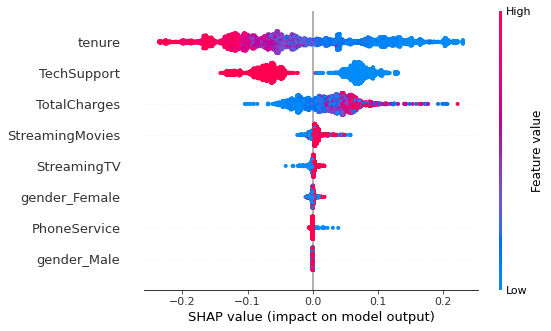

In [18]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

График summary_plot показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных). 

- Цвет точки - это значение признака
- То, насколько точка далека от вертикальной линии (серой) влево - показывает ее вклад как отрицательный
- То, насколько точка далека от вертикальной линии (серой) вправо - показывает ее положительный вклад

Как его читать: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать интересные выводы:
- чем дольше клиент пользуется услугами компании, тем меньше вероятность его ухода в отток
- клиенты, пользующиеся технической поддержкой, реже уходят в отток. Практически никто не ушел в отток из тех, кто использлвал поддержку. Это видно по кучности и цвета на графике.
- Чем выше общие расходы на сервисы, тем чаще клиенты уходят в отток


Можно даже просто взять средние значения SHAP для каждого признака

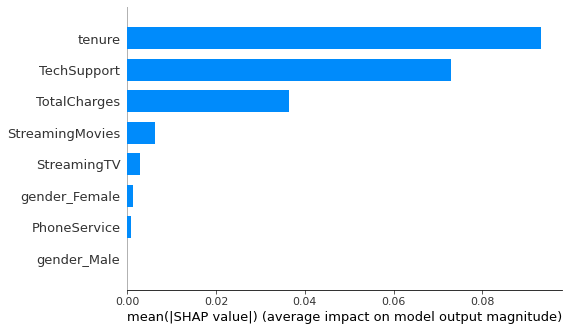

In [19]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Мы также видим, что выше описанные фичи в основном и определяют уход в отток

#### 6.  для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

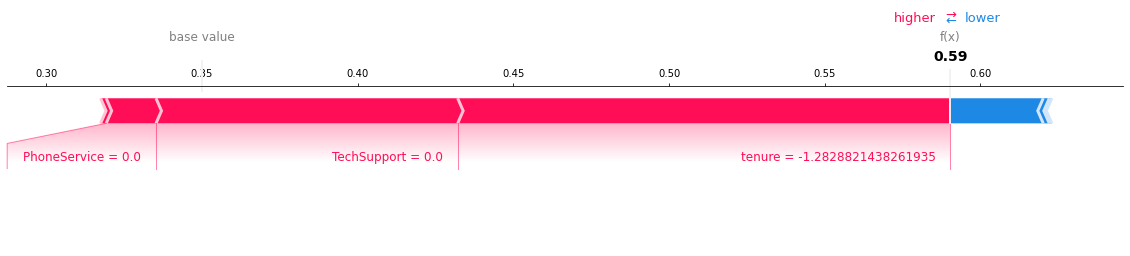

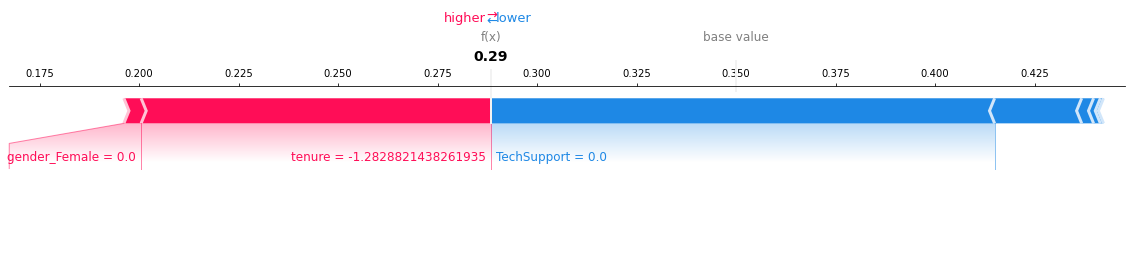

In [20]:

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
for i in (0, 2):
    shap.force_plot(explainer.expected_value, shap_values[i,:], X_train.iloc[0,:], matplotlib=True)

force_plot показывает значения SHAP для каждого клиента для каждого признака. По нему мы можем точно определить, какие факторы наиболее важны для каждого конкретного клиента, что позволяет нам соответствующим образом настроить наши последующие действия. Значения SHAP измеряют влияние каждой переменной на показатель оттока клиента (измеряя вероятность того, что он не уйдет в отток через месяц). Для каждого отдельного клиента это позволяет нам идентифицировать самые большие факторы риска (красные стрелки) и защитные факторы (синие стрелки) и рекомендовать индивидуальный план вмешательства.  

Например, для первого клиента мы видим, что основными драйверами толкающими клиента в отток являются техническая поддержка (ее отсутсвие) и срок пользования услугами компании. Следовательно, чтобы удержать клиента мы должны предложить ему техническую поддержку и организовать маркетинговую активность, для увеличени его срока взаимоотношений с комнанией

Во втором случае мы видим, что Техническа яподдержка наоборот препятсвуют оттоку. И в принцип по данному клиенту риск оттока минимальный. 